Dataset Source: https://www.kaggle.com/datasets/fvcoppen/solarpanelspower

In [1]:
from google.colab import files

files.upload()

Saving PV_Elec_Gas3.csv to PV_Elec_Gas3 (1).csv


{'PV_Elec_Gas3.csv': b'date,Cumulative_solar_power,kWh electricity/day,Gas/day\r\n26/10/2011,0.1,15.1,9\r\n27/10/2011,10.2,7.4,9.2\r\n28/10/2011,20.2,5.8,8\r\n29/10/2011,29.6,4.9,6.6\r\n30/10/2011,34.2,11.7,5.3\r\n31/10/2011,38,11,5.7\r\n1/11/2011,46.6,3.5,5.3\r\n2/11/2011,51.6,10.5,5.4\r\n3/11/2011,58.6,6.9,7.6\r\n4/11/2011,60.5,10.3,5.5\r\n5/11/2011,65.7,12,5.2\r\n6/11/2011,71.8,11.9,4.8\r\n7/11/2011,73.3,16.7,5.3\r\n8/11/2011,73.8,11.1,7.3\r\n9/11/2011,76.1,13,8.3\r\n10/11/2011,82.5,7.6,7.2\r\n11/11/2011,89.1,8.9,10.5\r\n12/11/2011,95.5,12.9,10.2\r\n13/11/2011,99.9,10.7,10.7\r\n14/11/2011,101.4,10.2,9.9\r\n15/11/2011,109.1,7.2,11.4\r\n16/11/2011,116,9.4,13.6\r\n17/11/2011,122.3,10.1,16.1\r\n18/11/2011,124.3,14.6,12.8\r\n19/11/2011,130.5,8.4,10.3\r\n20/11/2011,136.5,12.2,12.6\r\n21/11/2011,142.5,17.7,12.8\r\n22/11/2011,145,11.5,13.4\r\n23/11/2011,148.3,13.5,11.9\r\n24/11/2011,149.8,13,9.7\r\n25/11/2011,151.7,17.8,12.6\r\n26/11/2011,152.4,16.9,11.3\r\n27/11/2011,156.1,12.6,12.6\r\n28/

In [2]:
import pandas as pd

df = pd.read_csv("/content/PV_Elec_Gas3.csv", sep=",", header=0)
df.drop(['Cumulative_solar_power', 'Gas/day'],axis=1,inplace=True)
df.columns = ['date', 'usage']
df

,date,usage
0,26/10/2011,15.1
1,27/10/2011,7.4
2,28/10/2011,5.8
3,29/10/2011,4.9
4,30/10/2011,11.7
...,...,...
3299,6/11/2020,16.0
3300,7/11/2020,13.0
3301,8/11/2020,12.0
3302,9/11/2020,14.0


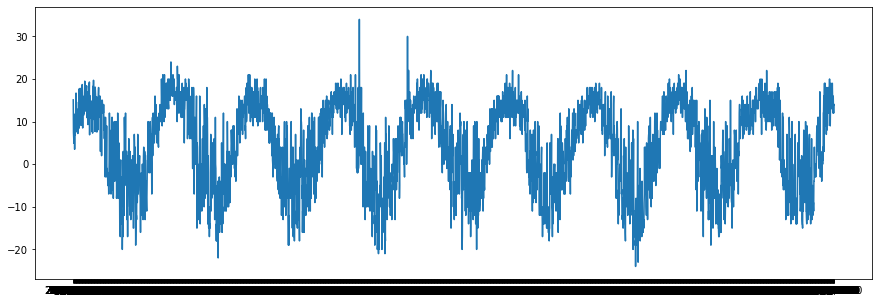

In [3]:
import matplotlib.pyplot as plt

dates = df['date'].values
usage  = df['usage'].values

plt.figure(figsize=(15,5))
plt.plot(dates, usage)

In [4]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

reshape_usage = usage.reshape(1,-1)
usages = min_max_scaler.fit_transform(reshape_usage.T).flatten()

In [5]:
threshold_mae = (usages.max() - usages.min()) * 10/100
threshold_mae

0.1

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(usages, dates, test_size=0.2, shuffle=False)

In [7]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(16, return_sequences=True),
  tf.keras.layers.LSTM(16),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [14]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1.0000e-04),
              metrics=["mae"])

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold_mae):
      print("\nProses Pelatihan Sudah Selesai!")
      self.model.stop_training = True
callbacks = myCallback()

In [15]:
history = model.fit(
    train_set,
    epochs=100,
    callbacks=callbacks,
    verbose=1)

Epoch 1/100
26/26 [==============================] - 7s 60ms/step - loss: 0.1291 - mae: 0.4792
Epoch 2/100
26/26 [==============================] - 2s 63ms/step - loss: 0.1224 - mae: 0.4656
Epoch 3/100
26/26 [==============================] - 2s 60ms/step - loss: 0.1161 - mae: 0.4523
Epoch 4/100
26/26 [==============================] - 2s 62ms/step - loss: 0.1086 - mae: 0.4359
Epoch 5/100
26/26 [==============================] - 2s 61ms/step - loss: 0.0988 - mae: 0.4138
Epoch 6/100
26/26 [==============================] - 2s 62ms/step - loss: 0.0857 - mae: 0.3822
Epoch 7/100
26/26 [==============================] - 2s 60ms/step - loss: 0.0683 - mae: 0.3364
Epoch 8/100
26/26 [==============================] - 2s 62ms/step - loss: 0.0476 - mae: 0.2737
Epoch 9/100
26/26 [==============================] - 2s 62ms/step - loss: 0.0286 - mae: 0.2066
Epoch 10/100
26/26 [==============================] - 2s 62ms/step - loss: 0.0172 - mae: 0.1597
Epoch 11/100
26/26 [=============================

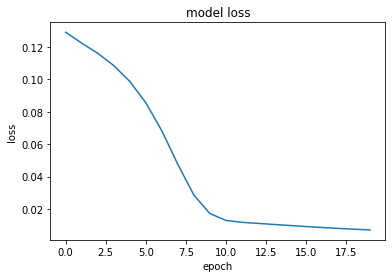

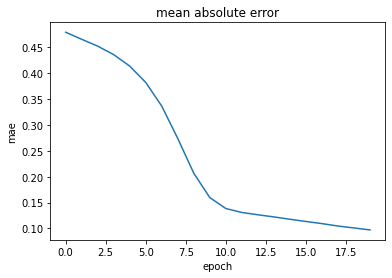

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['mae'])
plt.title('mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()